# **0. Datos del grupo e Importación del dataset**

## 0.1 Datos del grupo y enlace al repositorio de Github

Esta práctica ha sido realizada por el **Grupo 5**, formado por:
* Izan Sánchez Álvado (NIA: 100495774)
* Alba Tello Marcos (NIA: 100495755)

COMO YA SE HA COMENTADO EN CLASE, UTILIZAMOS EL MISMO REPOSITORIO PARA ESTA PRÁCTICA TAMBIÉN

El código completo con los respectivos commits se encuentra en el siguiente repositorio de GitHub:
https://github.com/albatellouc3m/Grupo5


## 0.2 Importación del dataset

In [50]:
import pandas as pd

datos_generales = pd.read_csv('./semillas.csv')

X = datos_generales.iloc[:, :-1].values  # Todas las columnas menos la última
y = datos_generales.iloc[:, -1].values   # La última columna

datos_generales.head()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


# **1. Comprobación de scalers visualmente utilizando PCA**

En esta sección, utilizamos PCA para elegir entre tres scalers de forma visual. Para ello, definimos los tres scalers y vamos probando con cada uno a representarlo en 2 dimensiones (reduciendo los 7 atributos a 2). De entre los tres gráfico escogemos el que tenga una varianza mayor.

**Cargamos las librerías necesarias**

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


## 1.1 Elección del mejor scaler
Vamos a representar gráficamente los tres scaler (MinMaxScaler, StandardScaler y RobustScaler) para seleccionar el mejor. Para conseguirlo, escalamos las variables (excepto la variable objetivo), luego usamos PCA para reducir la información a dos dimensiones y finalmente representamos los puntos en una gráfica.

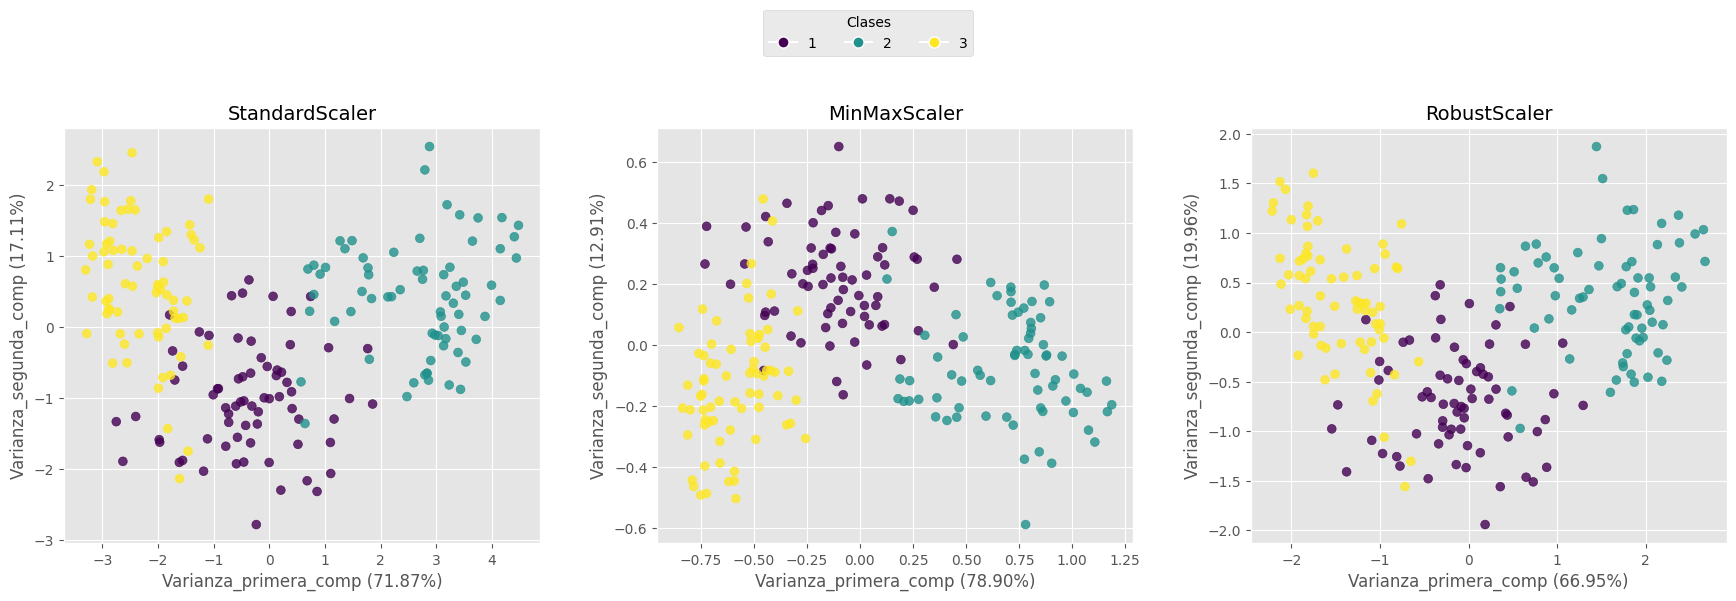

In [52]:
# MÉTODOS DE ESCALADO
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas (Simplemente diseño, para poner los tres gráficos en horizontal)

for idx, (nombre, scaler) in enumerate(scalers.items()):
    
    # Escalamos los datos
    X_scaled = scaler.fit_transform(X)
    
    # Aplicamos PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_scaled)

    # Visualizamos en 2D
    scatter = axes[idx].scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=pd.factorize(y)[0],
        cmap='viridis',
        s=40,
        alpha=0.8
    )
    
    axes[idx].set_title(f"{nombre}", fontsize=14)
    axes[idx].set_xlabel("Varianza_primera_comp ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100))
    axes[idx].set_ylabel("Varianza_segunda_comp ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100))
    axes[idx].grid(True)

# Leyenda común
etiquetas = sorted(set(y))
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=etiqueta,
               markerfacecolor=plt.cm.viridis(i / (len(etiquetas)-1)), markersize=8)
    for i, etiqueta in enumerate(etiquetas)
]

# Ajustamos la leyenda para separarla del gráfico
fig.legend(handles=handles, title="Clases", loc="upper center", ncol=len(etiquetas), fontsize=10, bbox_to_anchor=(0.5, 1.05))

# Ajustamos el layout para más espacio en la parte superior
plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Mayor espacio entre el gráfico y la leyenda
plt.show()


Al analizar la información de estos gráficos, podemos llegar a la conclusión de que MinMax es el mejor scaler ya que la varianza es más alta en este. Por ello, para el resto del código, utilizaremos la reducción de los datos de entrada con el scaler MinMaxScaler.

In [53]:

# REDUCCIÓN DE DIMENSIONALIDAD CON PIPELINE MINMAX
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usamos MinMaxScaler ya elegido anteriormente
    ('pca', PCA(n_components=2))
])

# Transformamos los datos
X_reduced = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

# Convertimos X_reduced a DataFrame para visualización
df_reduced = pd.DataFrame(X_reduced, columns=['X1', 'X2'])

# Mostramos las primeras filas
print(df_reduced.head())


         X1        X2
0  0.075029  0.129691
1 -0.024301  0.364120
2 -0.149375  0.456497
3 -0.180881  0.440557
4  0.250589  0.441297


# **2. Aplicación de técnicas de clustering (K-Means, Dendogramas, DBSCAN)**

Como hemos seleccionado MinMaxScaler como el método de escalado, ahora vamos a explorar técnicas de clustering. Trabajaremos con una versión de los datos en 2D, obtenida mediante PCA y escalada con MinMaxScaler. La idea del clustering es hallar agrupaciones con sentido en los datos, sin depender de una variable de respuesta. Vamos a probar y contrastar las siguientes técnicas:

* **K-Means**: se determinará el número de clusters más adecuado usando el método del codo y el índice silhouette.

* **Clustering Jerárquico**: utilizaremos un enfoque aglomerativo con *sklearn* y visualizaremos los reultados mediante dendogramas aplicando distintos métodos de linkage como *ward*, *average* y *complete*.

* **DBSCAN**: se buscarán agrupaciones según la densidad de los datos, lo que también permite detectar posibles valores atípicos (outliers). Para que funcione bien, será necesario ajustar parámetros como *minpts* y *eps*.

## 2.1. K-Means
El algoritmo **K-Means** funciona agrupando puntos de datos en un número (K) de clusters. Su objetivo principal es hacer que la distancia entre cada punto y el centro de su grupo (el centroide) sea lo más pequeña posible. El proceso es repetitivo, comienza asignando a cada punto al centroide más cercano, y luego se ajusta la posición de los centroides basándose en los puntos que se les han asignado. Para decidir cuántos clusters (K) son los mejores para un conjunto de datos, usaremos técnicas como el Método del Codo y el índice Silhouette.

In [54]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# Configuración de gráficos
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')


# Configuración warnings
# ==============================================================================
warnings.filterwarnings('ignore')


En esta parte del código, escalamos los datos.

In [55]:
# Escalado de datos
# ==============================================================================
X_reduced_scaled = scale(X_reduced)

### 2.1.1 Elbow method para K-Means

Vamos a calcular la **inercia** para k entre 2 y 10, y buscar el codo.


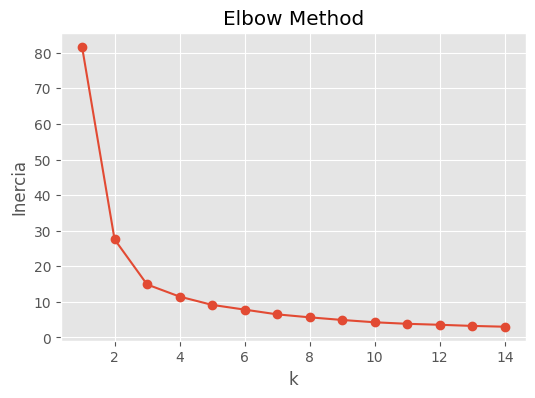

In [56]:
# Elbow method
inercia = []
Ks = range(1,15)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=495774).fit(X_reduced)
    inercia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inercia, '-o')
plt.xlabel('k'); plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.show()




El en método del codo buscamos el punto donde la inercia empieza a decrementar su valor, como vemos en la gráfica el mejor número de clusters es 3 (K=3), puesto que es el punto donde la gráfica comienza a decrementar su valor.

### 2.1.2 Silhouette analysis para K-Means

Para cada k entre 2 y 10, calculamos el silhouette score y lo graficamos.


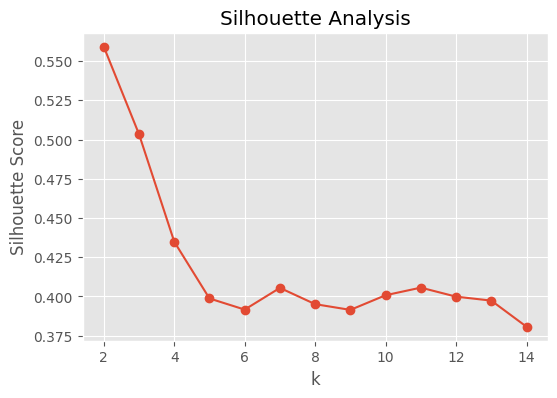

In [57]:
# Silhouette analysis
from sklearn.metrics import silhouette_score, adjusted_rand_score


sil_scores = []
Ks = range(2,15)

for k in Ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=495774).fit(X_reduced)
    sil_scores.append(silhouette_score(X_reduced, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Elegimos k que maximiza silhouette
k_opt = Ks[np.argmax(sil_scores)]


Con Silhouette, el número óptimo de clusters (k) es el que tiene el mayor score, el pico en la gráfica. En este caso el número óptimo de clusters sería 2.

### 2.1.3 Entrenamiento del Modelo

Una vez obtenido todos estos datos gracias a las gráficas,entrenamos el modelo utilizando el algoritmo KMeans, que permite ajustar varios parámetros:

* **n_clusters**: número de grupos (clusters) que se quieren formar

* **n_init**: número de veces que se ejecuta el algoritmo con diferentes inicializaciones

* **random_state**: fija una semilla para asegurar que los resultados sean reproducibles

In [58]:
# Creamos y entrenamos el modelo final con k_opt
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=495774)
modelo_kmeans.fit(X=X_reduced_scaled)

# Realizamos la predicción
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_reduced_scaled)

Podemos representar visualmente el cambio entre los clusters originales y los que se crean con el algoritmo de K-means de la siguiente forma:

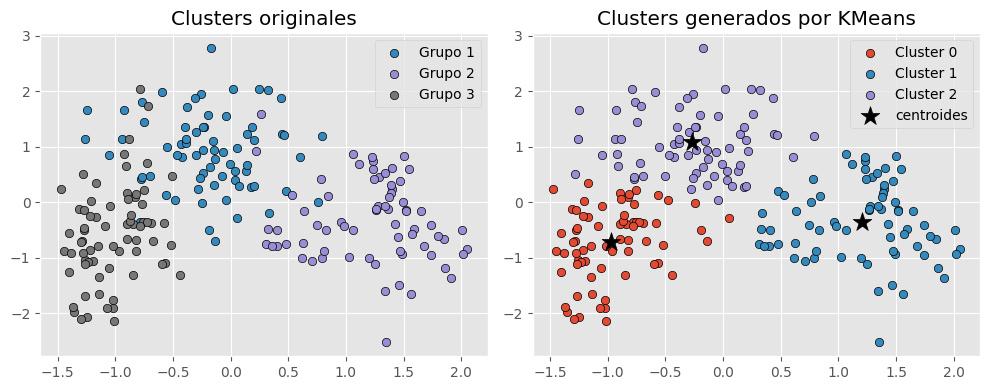

In [59]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_reduced_scaled[y == i, 0],
        y = X_reduced_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label = f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend()

# Clusters generados por KMeans
for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_reduced_scaled[y_predict == i, 0],
        y = X_reduced_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label = f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label = 'centroides'
)
ax[1].set_title('Clusters generados por KMeans')
ax[1].legend()
plt.tight_layout()
plt.show()


## 2.2 Cluster Jerárquico / Dendograma

El **clustering jerárquico** es un método para agrupar, en forma de árbol, datos sin necesidad de conocer de antemano cuántos grupos hay. Su forma más habitual, el enfoque aglomerativo, empieza tratando cada dato como un grupo separado y, paso a paso, va uniendo los más parecidos según una medida de distancia y un criterio de enlace como ward, average o complete. Vamos a representar los resutlados mediante dendogramas, que muestra como se organizan los datos.

In [60]:
# Escalado de las variables
# ==============================================================================
X_reduced_scaled = scale(X=X_reduced, axis=0, with_mean=True, with_std=True)

# Convertimos X_reduced_scaled a DataFrame para visualización
df_reduced = pd.DataFrame(X_reduced_scaled, columns=['X1', 'X2'])

# Mostramos las primeras filas
print(df_reduced.head())

         X1        X2
0  0.129757  0.554504
1 -0.042026  1.556821
2 -0.258332  1.951788
3 -0.312819  1.883636
4  0.433374  1.886796


Aquí tenemos la función que se encargará de representar el dendograma de un conjunto de datos:

In [61]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

### 2.2.1 Selección de linkage con dendrogramas

Probamos **ward**, **complete** y **average** con **distance_threshold=0**, luego truncamos a nivel 5.

Cuando aplicamos un clustering jerárquico debemos de escoger el tipo de linkage y la distancia. Entonces vamos creando diferentes modelos que utilicen distintos valores de esos conceptos expuestos y escogeremos el mejor de todos: 

In [62]:
from sklearn.cluster import AgglomerativeClustering

# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_reduced_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_reduced_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_reduced_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Ahora generamos los dendogramas de cada modelo:

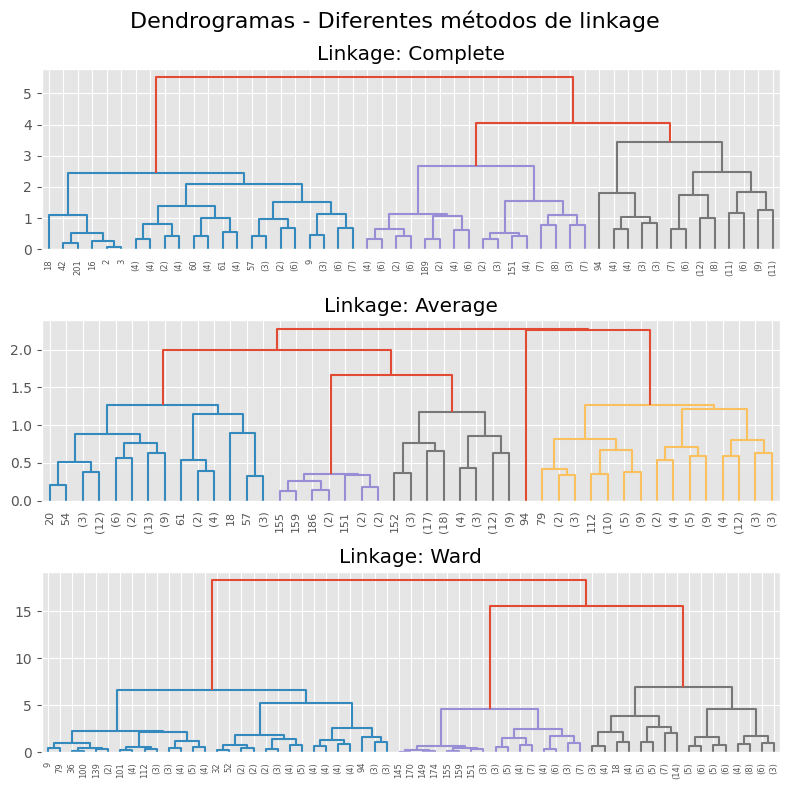

In [63]:
# Dibujamos los dendrogramas
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle('Dendrogramas - Diferentes métodos de linkage', fontsize=16)

plt.sca(axs[0])
plot_dendrogram(modelo_hclust_complete, truncate_mode="level", p=5)
plt.title("Linkage: Complete")

plt.sca(axs[1])
plot_dendrogram(modelo_hclust_average, truncate_mode="level", p=5)
plt.title("Linkage: Average")

plt.sca(axs[2])
plot_dendrogram(modelo_hclust_ward, truncate_mode="level", p=5)
plt.title("Linkage: Ward")

plt.tight_layout()
plt.show()

En la imagen se comparan tres dendogramas creados con distintos métodos de linkage dentro del clustering jerárquico. Estos métodos definen cómo se mide la distancia entre los grupos cuando se van uniendo:

* **Complete**: se basa en la distancia más grande entre elementos de distintos grupos. Suele formar clusters bien definidos, aunque puede verse afectado por valores atípicos.

* **Average**: calcula la distancia media entre todos los puntos de los dos grupos. Suele dar como resultado agrupaciones más equilibradas.

* **Ward**: busca reducir al mínimo la variación dentro de los grupos al ir combinándolos. Tiende a generar agrupamientos más uniformes en tamaño y forma.

Cada dendograma representa el proceso de agrupación paso a paso. A mayor altura de unión entre ramas, mayor es la distancia entre los grupos que se juntan. Esto ayuda a ver con claridad cuántos grupos tiene sentido formar, simplemente cortando el dendograma a una determinada altura.

### 2.2 Silhouette para cada linkage y distintos n_clusters

Para elegir entre los tres tipos de linkage (Complete, Average o Ward), podemos hacer uso de métricas como el silhouette score.

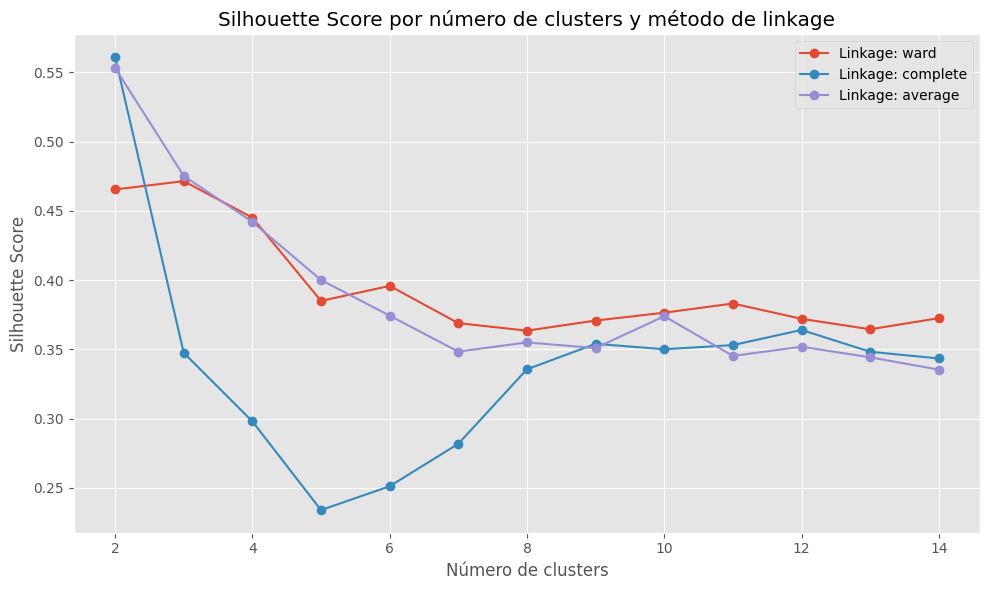

In [64]:
from sklearn.metrics import silhouette_score

# Parámetros
n_clusters_range = range(2, 15)
linkages = ['ward', 'complete', 'average']

# Diccionario para guardar los resultados
results = {linkage: [] for linkage in linkages}

# Calculamos los silhouette scores
for linkage in linkages:
    for n_clusters in n_clusters_range:
        if linkage == 'ward':
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        else:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='euclidean')
        labels = model.fit_predict(X_reduced)
        score = silhouette_score(X_reduced, labels)
        results[linkage].append(score)

# Mostramos los resultados
plt.figure(figsize=(10, 6))
for linkage in linkages:
    plt.plot(n_clusters_range, results[linkage], marker='o', label=f'Linkage: {linkage}')

plt.title('Silhouette Score por número de clusters y método de linkage')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Hemos probado los tres tipos de linkage (ward, average y complete) usando datos reducidos a dos dimensiones mediante PCA. Al evaluar la calidad de los clusters mediante el silhouette score con distintos números de clusters, el modelo con linkage 'ward' obtuvo el valor más alto, por lo que, junto con un n_clusters = 3, lo seleccionamos como el modelo jerárquico final.

In [65]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 3
)
modelo_hclust_ward.fit(X=X_reduced_scaled)

AgglomerativeClustering(n_clusters=3)

## 2.3 Clustering basado en densidad / DBSCAN

**DBSCAN** es un algoritmo de agrupamiento que se basa en la densidad de los datos. Detecta grupos como zonas donde hay muchos puntos cercanos entre sí, separadas por áreas con pocos datos. Los puntos que quedan aislados se consideran ruido. Funciona con dos parámetros principales: epsilon, que define la distancia máxima para que dos puntos se consideren vecinos, y min_samples, que indica cuántos vecinos necesita un punto para formar parte de un grupo. Gracias a esto, DBSCAN puede identificar agrupaciones con formas irregulares y manejar bien los valores atípicos.

Text(0.5, 1.0, 'Nube de puntos iniciales')

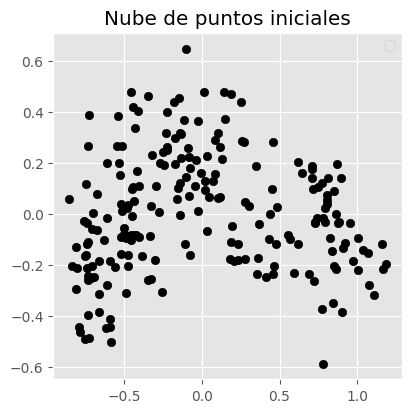

In [66]:


# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_reduced[:, 0],
    y = X_reduced[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales')



     


### 2.3.1 k-distance para distintos min_samples

Probaremos *min_samples* ∈ {3,5,10} y dibujaremos las curvas k-distance para sugerir ε.




Text(0.5, 1.0, 'Clusterings generados por DBSCAN')

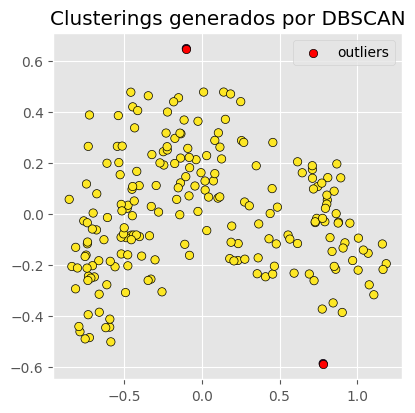

In [67]:

from sklearn.cluster import DBSCAN

# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.19,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_reduced)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_reduced[:, 0],
    y = X_reduced[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_reduced[labels == -1, 0],
    y = X_reduced[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')


De esta gráfica podemos sacar el número de clusters y de outliers que existen:

In [68]:


# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')



     


Número de clusters encontrados: 1
Número de outliers encontrados: 2


Ahora debemos determinar un valor correcto del hiperparámetro EPS (epsilon). Este hiperparámetro determina el radio máximo para determinar vecinos. Es decir, que si dos puntos se encuentran a una distancia menor o igual a ese EPS, son vecinos. La influencia de epsilon se puede explicar de la siguiente forma:

 - eps pequeño → solo puntos muy cercanos forman grupos → más clusters pequeños o incluso mucho ruido (puntos sin cluster).
 - eps grande → más puntos considerados vecinos → menos clusters, aglomeraciones más grandes.

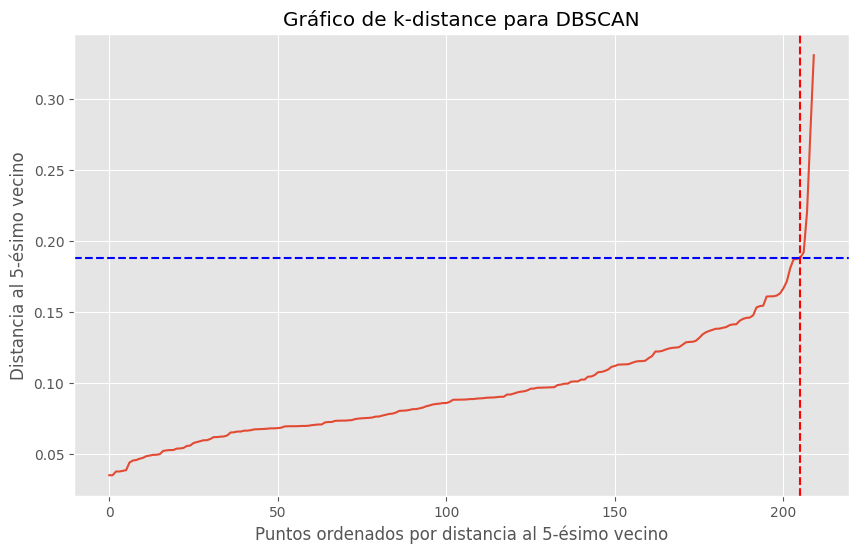

eps sugerido ≈ 0.188


In [69]:


from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 5

# Ajustamos el modelo de vecinos más cercanos
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_reduced)
distances, indices = nn.kneighbors(X_reduced)

# Ordenamos las distancias del min_samples-ésimo vecino
sorted_distances = np.sort(distances[:, min_samples - 1], axis=0)

# Elegimos un punto cerca del "codo" (ajustar si es necesario)
x_point = len(sorted_distances) - 5
y_value = sorted_distances[x_point]

# Gráfico de k-distancia
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.axvline(x=x_point, color='r', linestyle='--')
plt.axhline(y=y_value, color='b', linestyle='--')
plt.title('Gráfico de k-distance para DBSCAN')
plt.xlabel(f'Puntos ordenados por distancia al {min_samples}-ésimo vecino')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino')
plt.grid(True)
plt.show()

print(f"eps sugerido ≈ {y_value:.3f}")



     



Ahora utilizamos ese epsilon sugerido (0.188) y aplicamos el DBSCAN final:

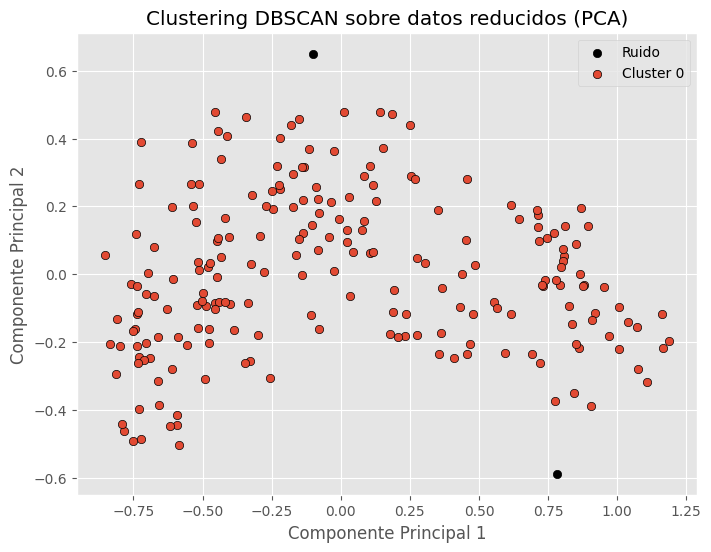

In [70]:



# Usamos el eps visualizado
eps_optimo = y_value

modelo_dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples)
modelo_dbscan.fit(X_reduced)

# Etiquetas asignadas a cada punto (-1 es ruido)
labels_dbscan = modelo_dbscan.labels_

# Visualizamos los clusters
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(labels_dbscan):
    cluster_mask = labels_dbscan == cluster_id
    color = 'black' if cluster_id == -1 else None  # Ruido en negro
    plt.scatter(
        X_reduced[cluster_mask, 0],
        X_reduced[cluster_mask, 1],
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Ruido",
        edgecolor='k',
        c=color
    )

plt.title('Clustering DBSCAN sobre datos reducidos (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()



     



# 3. Análisis de métodos de clustering

En esta sección, procedemos a analizar y comparar los resultados obtenidos de la aplicación de los tres métodos de clustering estudiados: K-Means, Clustering Jerárquico y DBSCAN. 
El objetivo es evaluar qué tan bien cada algoritmo logra agrupar los datos reducidos en 2 dimensiones y cómo estas agrupaciones se relacionan con las claves originales de las semillas.

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que `y` contiene las clases originales (etiquetas de semillas)
# y `X_reduced_scaled` son los datos reducidos en 2 dimensiones

# Convertimos los clusters generados por los 3 métodos y las clases originales a DataFrames
kmeans_df = pd.DataFrame({'Cluster_KMeans': modelo_kmeans.labels_, 'Clase_Original': y, 'X1': X_reduced_scaled[:, 0], 'X2': X_reduced_scaled[:, 1]})
hclust_df = pd.DataFrame({'Cluster_HClust': modelo_hclust_ward.labels_, 'Clase_Original': y, 'X1': X_reduced_scaled[:, 0], 'X2': X_reduced_scaled[:, 1]})
dbscan_df = pd.DataFrame({'Cluster_DBSCAN': modelo_dbscan.labels_, 'Clase_Original': y, 'X1': X_reduced[:, 0], 'X2': X_reduced[:, 1]})


## 3.1 Visualización de la distribución de los Clusters con Boxplots

Los boxplots nos permiten visualizar la distribución de cada componente principal (X1 y X2) dentro de los clusters identificados por cada algoritmo. Esto nos da una idea de la dispersión y los valores centrales de los datos en cada gurpo, ayudando a caracterizar los clusters.

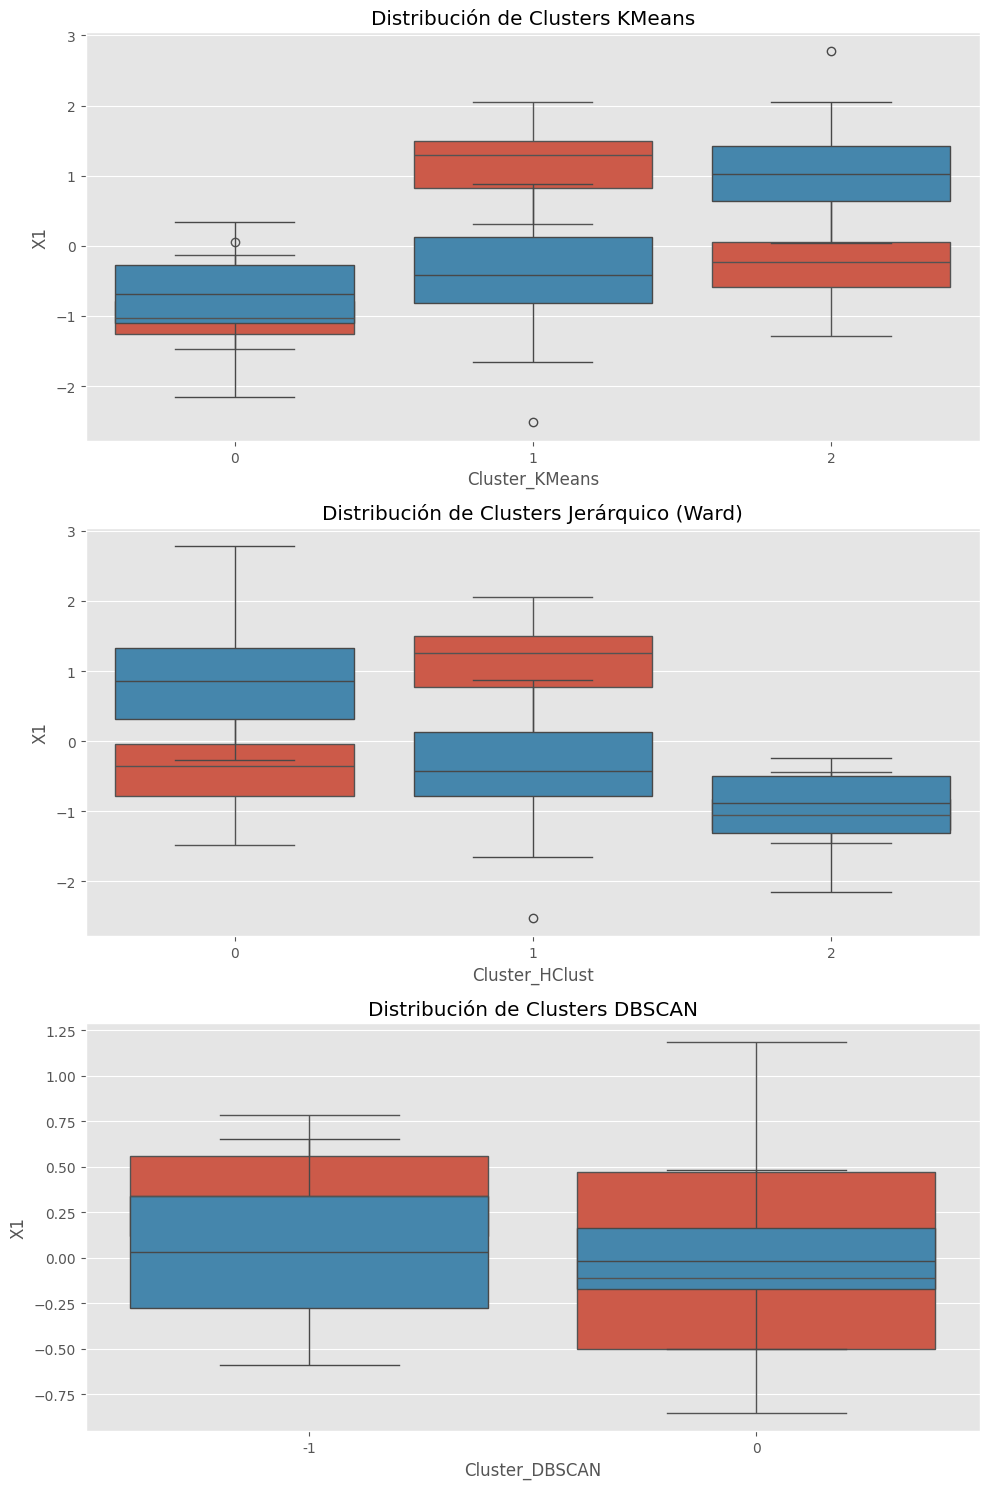

In [72]:

# === Boxplots para comparar distribución de los clusters ===
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# KMeans
sns.boxplot(data=kmeans_df, x='Cluster_KMeans', y='X1', ax=axs[0])
sns.boxplot(data=kmeans_df, x='Cluster_KMeans', y='X2', ax=axs[0])
axs[0].set_title('Distribución de Clusters KMeans')

# HClust
sns.boxplot(data=hclust_df, x='Cluster_HClust', y='X1', ax=axs[1])
sns.boxplot(data=hclust_df, x='Cluster_HClust', y='X2', ax=axs[1])
axs[1].set_title('Distribución de Clusters Jerárquico (Ward)')

# DBSCAN
sns.boxplot(data=dbscan_df, x='Cluster_DBSCAN', y='X1', ax=axs[2])
sns.boxplot(data=dbscan_df, x='Cluster_DBSCAN', y='X2', ax=axs[2])
axs[2].set_title('Distribución de Clusters DBSCAN')

plt.tight_layout()
plt.show()


## 3.2 Interpretación de los Boxplots


Al observar los boxplots generados para cada método de clustering, identificamos las siguientes características

### 3.2.1 K-Means

Los boxplots de K-Means (con 3 clusters) muestran una separación clara en ambas componentes principales.
En X1, el Cluster 0 tiene valores negativos, el Cluster 1 se agrupa alrededor de 0, y el Cluster 2 concentra los valores positivos. Las cajas tienen tamaños parecidos, lo que indica dispersión similar.
En X2, la separación también es evidente: el Cluster 0 presenta valores más bajos, el Cluster 1 intermedios y el Cluster 2 los más altos.
Se observan algunos outliers en los tres grupos, pero en general los valores están bien concentrados.
Esto sugiere que K-Means ha identificado tres grupos compactos y bien separados, coherentes con su forma de agrupar por distancia a los centroides.

### 3.2.2 Custering Jerárquico(ward)

El método jerárquico con enlace ward también consigue una buena separación en ambas componentes.
En X1, se distingue un grupo con valores negativos (Cluster 2), otro intermedio (Cluster 0) y uno con valores más positivos (Cluster 1). Las cajas tienen tamaños algo distintos, pero no extremos.
En X2, ocurre algo similar: Cluster 2 concentra valores bajos, Cluster 0 valores intermedios y Cluster 1 los más altos.
Aunque hay algo más de dispersión en comparación con K-Means, los grupos siguen bien diferenciados.
Este resultado confirma que el clustering jerárquico con ward detecta una estructura parecida a la de K-Means, aunque con ligeras diferencias en la forma de agrupar.

### 3.2.3 DBSCAN

En el caso de DBSCAN, los boxplots muestran una estructura distinta.
Para X1, el Cluster -1 (ruido) presenta una gran dispersión, con valores repartidos en todo el rango. El Cluster 0 también tiene bastante variabilidad, aunque algo menor.
En X2, ocurre lo mismo: el grupo de ruido tiene valores muy repartidos, y el Cluster 0 muestra más dispersión que los grupos de K-Means o Ward.
En conjunto, DBSCAN ha detectado solo un grupo principal y muchos puntos considerados como ruido. Esto es consistente con su enfoque basado en densidad: encuentra zonas densas (Cluster 0) y deja fuera los puntos dispersos (-1).
Sin embargo, no logra separar claramente tres grupos como los otros métodos.

## 3.3 Conclusión

**¿Cuál de los métodos de clustering
captura mejor la estructura de clusters de este problema?**

Tanto K-Means como el Clustering Jerárquico con enlace ward (ambos configurados con 3 clusters) capturan bien la estructura del conjunto de datos en dos dimensiones.
En sus scatter plots se observan tres grupos bien definidos, y los boxplots muestran separaciones claras y bastante compactas en X1 y X2 para cada cluster.

En cambio, DBSCAN (con ϵ = 0.188 y min_samples = 5) detecta solo dos clusters y clasifica muchos puntos como ruido. Aunque sí identifica zonas densas válidas, no consigue recuperar los tres grupos principales. Además, el Cluster 0 presenta mayor dispersión, como se aprecia en sus boxplots.


**¿Hay relación entre los clusters obtenidos y las clases de semillas
originales?**

Sí. K-Means y el Clustering Jerárquico (ward) muestran una fuerte coincidencia visual con las tres clases originales.
Aunque estos algoritmos no utilizan las etiquetas durante el proceso, la estructura de los datos permite una separación natural en tres grupos que coincide con los tipos de semillas.

DBSCAN, en cambio, no refleja tan claramente esas tres clases. Detecta dos regiones densas y clasifica el resto como ruido. Aun así, esas zonas densas parecen agrupar datos de una o dos clases concretas, aunque sin la misma precisión que los otros métodos.